<a href="https://colab.research.google.com/github/DAnand05/Trash_Sorter/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/Dataset.zip

/content/drive/MyDrive/Dataset.zip


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras.layers as tkl
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
import os

In [6]:
# Load your dataset and split it into training and validation sets
data_dir = '/content/dataset-resized'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed = 1227,
  image_size=(224, 224),
  batch_size=32)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [7]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="validation",
  seed = 1227,
  image_size=(224, 224),
  batch_size=32)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


In [9]:
val_batches = tf.data.experimental.cardinality(valid_ds)

In [10]:
val_batches = tf.data.experimental.cardinality(valid_ds)
test_ds = valid_ds.take(val_batches // 5)
valid_ds = valid_ds.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Number of validation batches: 13
Number of test batches: 3


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
# Use data augmentation to add more data for training
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# Choose a pre-trained model to use as the basis for transfer learning
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [15]:
base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

In [16]:
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
# Compile the model with a loss function and an optimizer
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [17]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
initial_epochs = 80

In [19]:
callbacks_list = [ModelCheckpoint(filepath='model.keras', monitor='val_accuracy',
                                   verbose=1, save_best_only=True, save_weights_only=False, mode='max')]
csv_logger = CSVLogger('modeltraining.log', separator=',', append=False)

# Train the model on the training set
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=(valid_ds),
                    callbacks=(callbacks_list+[csv_logger]))

Epoch 1/80
64/64 [==============================] - ETA: 0s - loss: 12.4845 - accuracy: 0.5920
Epoch 1: val_accuracy improved from -inf to 0.72372, saving model to model.keras
64/64 [==============================] - 32s 301ms/step - loss: 12.4845 - accuracy: 0.5920 - val_loss: 9.7902 - val_accuracy: 0.7237
Epoch 2/80
64/64 [==============================] - ETA: 0s - loss: 7.9977 - accuracy: 0.7305
Epoch 2: val_accuracy improved from 0.72372 to 0.80929, saving model to model.keras
64/64 [==============================] - 12s 185ms/step - loss: 7.9977 - accuracy: 0.7305 - val_loss: 6.2188 - val_accuracy: 0.8093
Epoch 3/80
64/64 [==============================] - ETA: 0s - loss: 5.2211 - accuracy: 0.7567
Epoch 3: val_accuracy did not improve from 0.80929
64/64 [==============================] - 12s 181ms/step - loss: 5.2211 - accuracy: 0.7567 - val_loss: 4.1591 - val_accuracy: 0.8044
Epoch 4/80
64/64 [==============================] - ETA: 0s - loss: 3.4721 - accuracy: 0.7982
Epoch 4: v

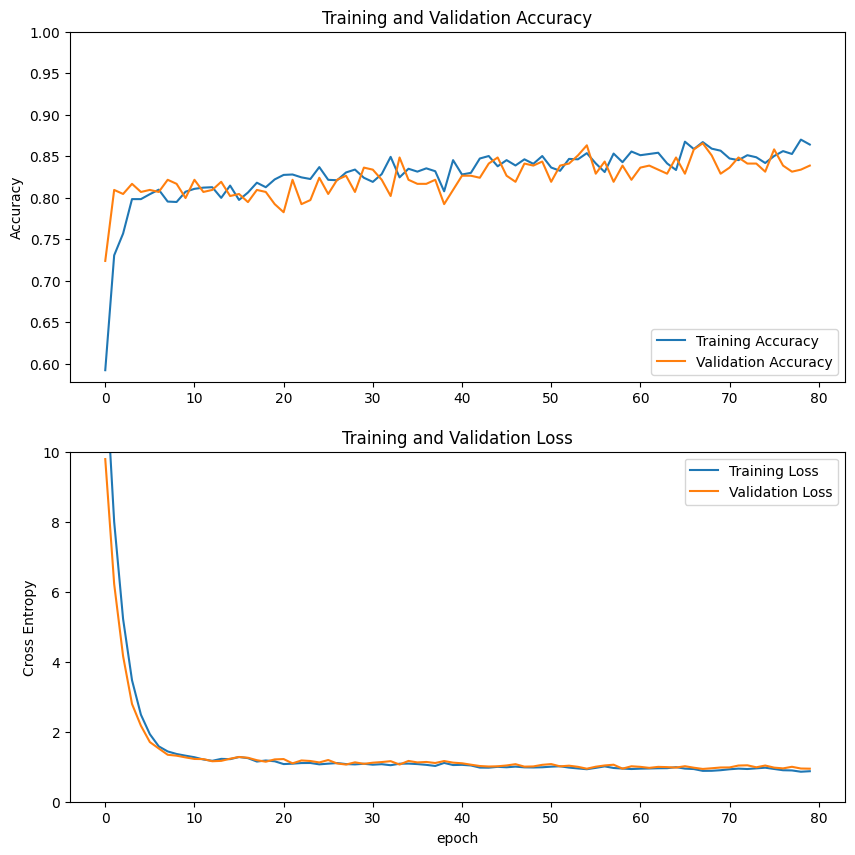

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# # # Fine-tune from this layer onwards
# # fine_tune_at = 13

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

Number of layers in the base model:  22


In [22]:
for layer in base_model.layers:
    layer.trainable = True

In [23]:
base_model.trainable = True
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              525312

In [25]:
total_epochs=160

In [26]:
# Fine-tune the model on the training set
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds,
                         callbacks=(callbacks_list+[csv_logger]))

Epoch 80/160
64/64 [==============================] - ETA: 0s - loss: 1.5139 - accuracy: 0.6325
Epoch 80: val_accuracy did not improve from 0.86553
64/64 [==============================] - 58s 591ms/step - loss: 1.5139 - accuracy: 0.6325 - val_loss: 7.9742 - val_accuracy: 0.2910
Epoch 81/160
64/64 [==============================] - ETA: 0s - loss: 1.3911 - accuracy: 0.6489
Epoch 81: val_accuracy did not improve from 0.86553
64/64 [==============================] - 34s 529ms/step - loss: 1.3911 - accuracy: 0.6489 - val_loss: 1.6294 - val_accuracy: 0.6577
Epoch 82/160
64/64 [==============================] - ETA: 0s - loss: 1.1690 - accuracy: 0.7344
Epoch 82: val_accuracy did not improve from 0.86553
64/64 [==============================] - 34s 525ms/step - loss: 1.1690 - accuracy: 0.7344 - val_loss: 1.3381 - val_accuracy: 0.6993
Epoch 83/160
64/64 [==============================] - ETA: 0s - loss: 0.9996 - accuracy: 0.7888
Epoch 83: val_accuracy did not improve from 0.86553
64/64 [=====

In [27]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(test_ds)
print('Validation loss: {}, Validation accuracy: {}'.format(val_loss, val_acc))

3/3 [==============================] - 1s 151ms/step - loss: 0.3780 - accuracy: 0.9167
Validation loss: 0.37795236706733704, Validation accuracy: 0.9166666865348816


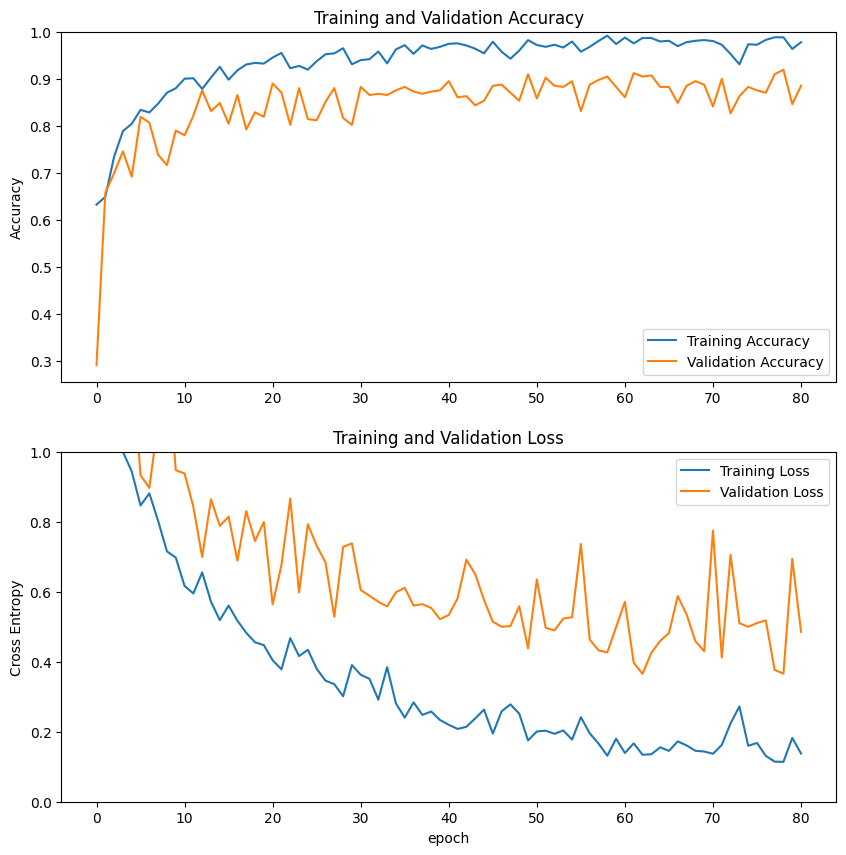

In [28]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  22


In [30]:
base_model.trainable = True
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              525312

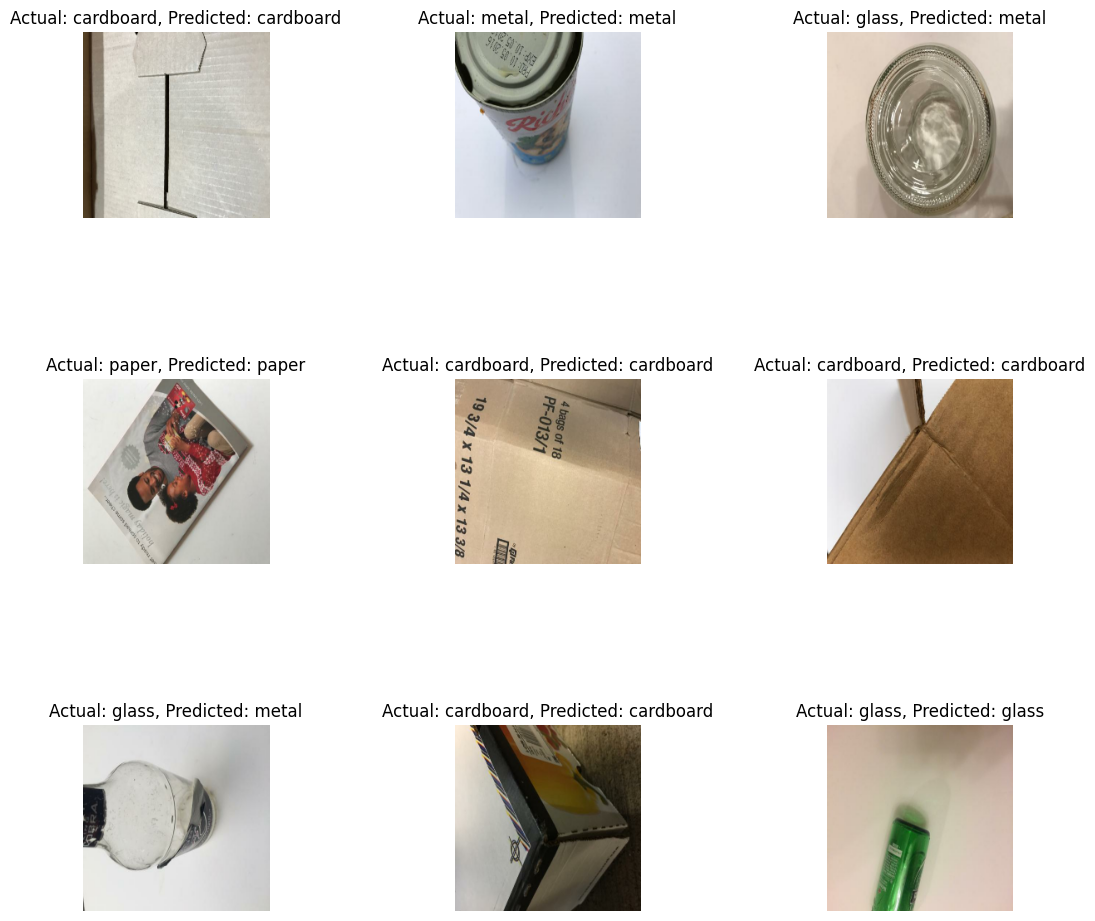

In [32]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    actual_label = class_names[label_batch[i]]
    predicted_label = class_names[np.argmax(predictions[i])]
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")

# Adjust the space between the plots
plt.subplots_adjust(wspace=1, hspace=0.5)

plt.show()

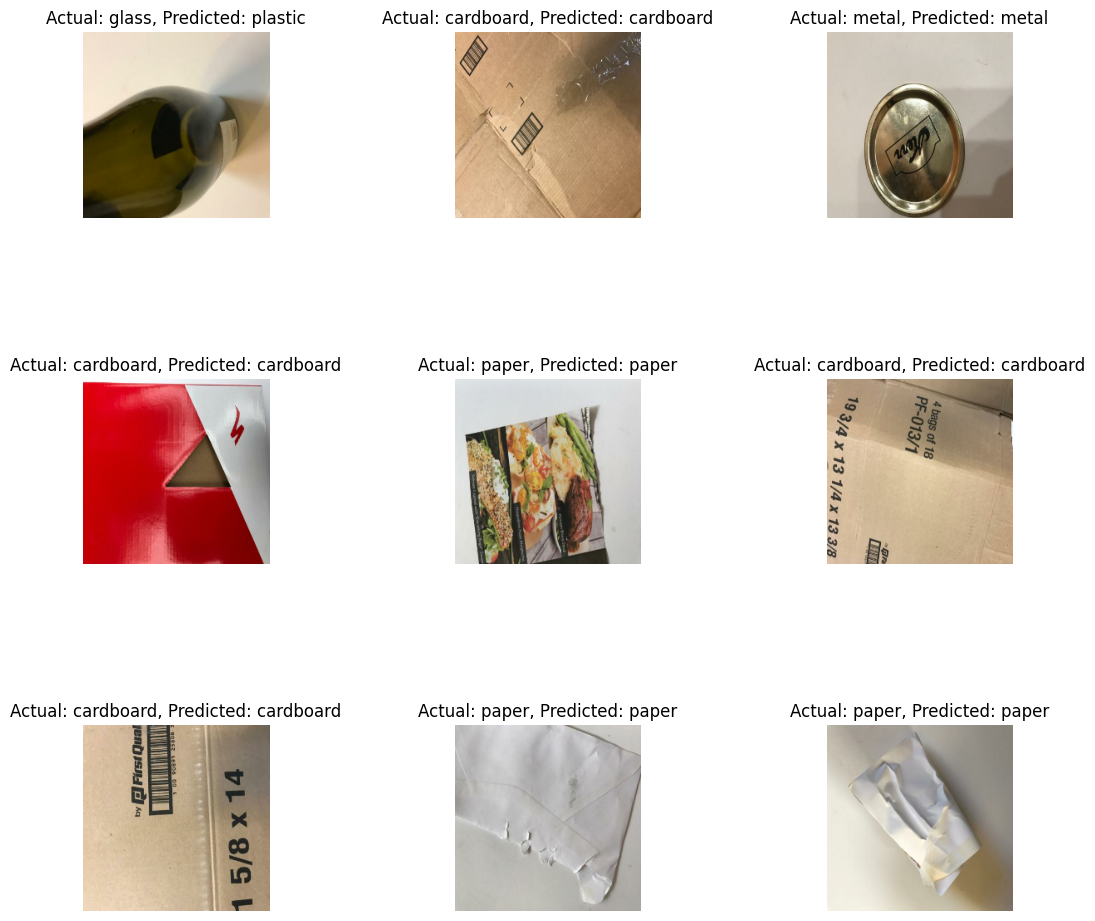

In [33]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    actual_label = class_names[label_batch[i]]
    predicted_label = class_names[np.argmax(predictions[i])]
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")

# Adjust the space between the plots
plt.subplots_adjust(wspace=1, hspace=0.5)

plt.show()

1/1 [==============================] - 0s 28ms/step


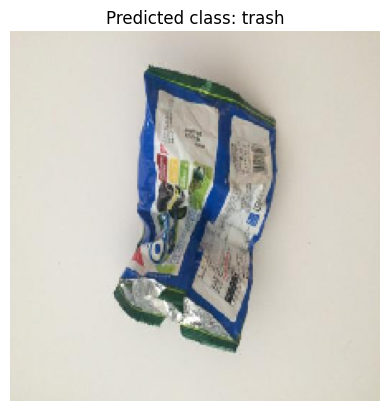

In [44]:

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt

# Load the image
img = image.load_img('/content/drive/MyDrive/plastic.jpg', target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the shape that the model expects
img_array_expanded = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same preprocessing function you used during training
img_array_preprocessed = preprocess_input(img_array_expanded)

# Make a prediction
predictions = model.predict(img_array_preprocessed)

# Get the predicted class
predicted_class = class_names[np.argmax(predictions[0])]

# Display the image along with the predicted class
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 45ms/step


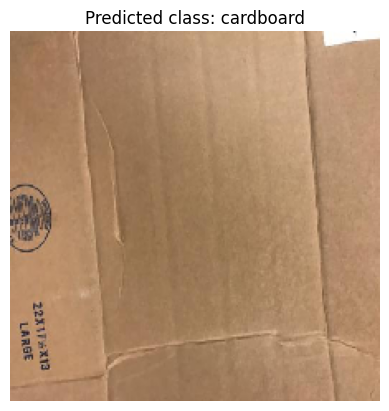

In [45]:
# Load the image
img = image.load_img('/content/drive/MyDrive/cardboard.jpg', target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the shape that the model expects
img_array_expanded = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same preprocessing function you used during training
img_array_preprocessed = preprocess_input(img_array_expanded)

# Make a prediction
predictions = model.predict(img_array_preprocessed)

# Get the predicted class
predicted_class = class_names[np.argmax(predictions[0])]

# Display the image along with the predicted class
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 25ms/step


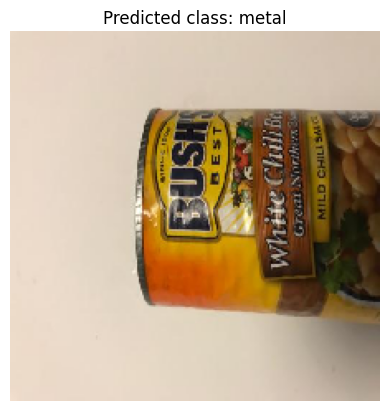

In [46]:
# Load the image
img = image.load_img('/content/drive/MyDrive/metal.jpg', target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the shape that the model expects
img_array_expanded = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same preprocessing function you used during training
img_array_preprocessed = preprocess_input(img_array_expanded)

# Make a prediction
predictions = model.predict(img_array_preprocessed)

# Get the predicted class
predicted_class = class_names[np.argmax(predictions[0])]

# Display the image along with the predicted class
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 18ms/step


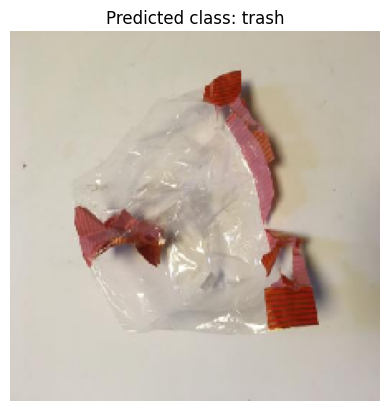

In [47]:
# Load the image
img = image.load_img('/content/drive/MyDrive/paper.jpg', target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the shape that the model expects
img_array_expanded = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same preprocessing function you used during training
img_array_preprocessed = preprocess_input(img_array_expanded)

# Make a prediction
predictions = model.predict(img_array_preprocessed)

# Get the predicted class
predicted_class = class_names[np.argmax(predictions[0])]

# Display the image along with the predicted class
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

In [48]:
model.save('Trash_Classifier.keras')

In [49]:
model.save('Trash_Classifier.h5')